In [2]:
from itertools import product
import torch
import tqdm
import math
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import variance_norms, isometry_gap, dataset_configs


# Define the MLP model with layer normalization
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_classes, activation, normalization, **kwargs):
        super(MLP, self).__init__()
        if normalization == 'LN':
            self.norm = nn.LayerNorm
        elif normalization == 'BN':
            self.norm = nn.BatchNorm1d
        elif normalization == 'None':
            self.norm = nn.Identity
        if not isinstance(input_size, int):
            p = 1
            for s in input_size:
                p *= s
            input_size = p

        self.layers = nn.Sequential()
        hidden_sizes = [input_size] + hidden_sizes + [num_classes]
        num_layers = len(hidden_sizes)
        # self.layers.add_module('fc-0', nn.Linear(input_size, hidden_size))
        # self.layers.add_module('norm-0', self.norm(hidden_size))

        for i, (h1,h2) in enumerate(zip(hidden_sizes[:-1],hidden_sizes[1:])):
            self.layers.add_module(f'act-{i}', getattr(nn, activation)())
            self.layers.add_module(f'norm-{i}', self.norm((h1)))
            self.layers.add_module(f'fc-{i}', nn.Linear(h1, h2))

        # self.layers.add_module(f'fc-{num_layers - 1}', nn.Linear(hidden_size, num_classes))
        self.apply(self.init_weights)

    def init_weights(self, layer):
        if isinstance(layer, nn.Linear):
            std = 1 / math.sqrt(layer.weight.size(1))
            nn.init.normal_(layer.weight, mean=0, std=std)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        hidden_layers = []
        for i, (name, layer) in enumerate(self.layers.named_children()):
            x = layer(x)
            hidden_layers.append((name, x))
        output = x
        return output, hidden_layers

class CNN(nn.Module):
    def __init__(self, input_size, conv_channels, fc_layers, num_classes, activation, normalization, **kwargs):
        super(CNN, self).__init__()

        if normalization == 'LN':
            self.norm = nn.LayerNorm
        elif normalization == 'None':
            self.norm = nn.Identity

        self.layers = nn.Sequential()

        # Convolutional layers
        in_channels = input_size[2]
        for i, out_channels in enumerate(conv_channels):
            self.layers.add_module(f'conv-{i}', nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            self.layers.add_module(f'norm-{i}', self.norm((out_channels, input_size[0] // (2 ** i), input_size[1] // (2 ** i))))
            self.layers.add_module(f'act-{i}', getattr(nn, activation)())
            self.layers.add_module(f'pool-{i}', nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels

        # Flatten layer
        self.layers.add_module('flatten', nn.Flatten())

        # Fully connected layers
        fc_input_size = conv_channels[-1] * input_size[0] // (2 ** len(conv_channels)) * input_size[1] // (2 ** len(conv_channels))
        for i in range(len(fc_layers)):
            self.layers.add_module(f'fc-{i}', nn.Linear(fc_input_size, fc_layers[i]))
            self.layers.add_module(f'norm-fc-{i}', self.norm(fc_layers[i]))
            self.layers.add_module(f'act-fc-{i}', getattr(nn, activation)())
            fc_input_size = fc_layers[i]

        # Output layer
        self.layers.add_module(f'fc-out', nn.Linear(fc_layers[-1], num_classes))

    def forward(self, x):
        hidden_layers = []
        for i, (name, layer) in enumerate(self.layers.named_children()):
            x = layer(x)
            hidden_layers.append((name, x))
        output = x
        return output, hidden_layers


def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs, hidden = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss


def evaluate_model(model, data_loader, criterion, device):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs, hidden = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

# h must be n x d, where d >= n
def isometry_gap(h, epsilon = 0, reduce_mean = False):
    if reduce_mean:
        h = h - h.mean(dim=1,keepdim=True)
    G = h @ h.t()
    vals = torch.linalg.eigvalsh(G) + epsilon
    log_vals = torch.log(vals)
    mean_log_vals = torch.mean(log_vals)
    log_mean_vals = torch.log(torch.mean(vals))
    iso_gap = log_mean_vals - mean_log_vals
    return iso_gap

def variance_norms(tensor,reduce_mean=False, dim=0):
    if reduce_mean:
        tensor = tensor - tensor.mean(dim=dim,keepdim=True)
    row_norms = torch.norm(tensor, dim=dim)  # Compute the norms of each row
    mean_norm = torch.mean(row_norms)  # Compute the mean norm
    var_norm = torch.var(row_norms)  # Compute the variance of norms
    return var_norm / mean_norm**2

def run_experiment(config):
    def record_results(model, loader, df, stage, num_batches = 5):
        # Record results
        for i, (images, labels) in enumerate(loader):
            if i > num_batches:
                break
            images = images.to(device)
            labels = labels.to(device)

            outputs, hidden = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            for li, (l, h) in enumerate(hidden):
                h = h.flatten(1)
                ig = isometry_gap(h, reduce_mean=True, epsilon=1e-8).item()
                nb = variance_norms(h, reduce_mean=True, ).item()
                df.append({**config,
                    'l': li,
                    'layer': l,
                    'iso_gap': ig,
                    'norm_bias': nb,
                    'stage': stage,
                    'loss': loss.item(),
                    'accuracy': (predicted == labels).sum().item() / len(labels),
                    'epoch': epoch,
                    'i': i
                })

    # Data preprocessing
    ds_config = dataset_configs[config['dataset']]
    transform = ds_config['transform']
    config['input_size'] = ds_config['input_size']
    config['num_classes'] = ds_config['num_classes']

    train_dataset = getattr(datasets, config['dataset'])(root='./data', train=True, transform=transform, download=True)
    test_dataset = getattr(datasets, config['dataset'])(root='./data', train=False, transform=transform, download=True)

    train_loader = DataLoader(dataset=train_dataset, batch_size=config['batch_size'], shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=config['batch_size'], shuffle=False)

    # Create the model, loss function, and optimizer
    device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

    df = []
    models = {
        'CNN': CNN,
        'MLP': MLP,
    }
    model = models[config['model']](**config).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'])

    for epoch in tqdm.trange(config['num_epochs']):
        if epoch > 0:
            loss = train_model(model, train_loader, criterion, optimizer, device)
            print(f'Epoch [{epoch + 1}/{config["num_epochs"]}], Train Loss: {loss.item():.4f}')
        record_results(model, train_loader, df, 'train')

        # Evaluate the model on test data
        accuracy = evaluate_model(model, test_loader, criterion, device)
        print(f'Test Accuracy of the model on the 10000 test images: {100 * accuracy:.2f}%')
        record_results(model, test_loader, df, 'test')

    df = pd.DataFrame(df)
    return df


def generate_configs(config_grid):
    config_list = list(product(*config_grid.values()))
    config_dicts = []
    for config_tuple in config_list:
        config_dict = dict(zip(config_grid.keys(), config_tuple))
        config_dicts.append(config_dict)
    return config_dicts



def compute_beta(act):
    x = torch.randn(1000000)
    c0 = act(x).mean()
    c1 = (act(x)*x).mean()
    csum2 = (act(x)**2).mean()
    beta0 = 2 - c1**2 / (csum2 - c0**2)
    # c0, c1, csum2, beta0
    return beta0.item()

def run_experiment_grid(config_grid):
    # Generate all possible configurations from the config grid
    config_list = generate_configs(config_grid)

    # Run the experiments for each config
    all_results_df = []
    for config in config_list:
        print(f"Running experiment for config: {config}")
        results_df = run_experiment(config)
        all_results_df.append(results_df)

    # Concatenate the results of all experiments into a single DataFrame
    final_results_df = pd.concat(all_results_df, ignore_index=True)
    final_results_df['beta'] = 0
    for act in final_results_df.activation.unique():
        F = getattr(nn, act)()
        beta = compute_beta(F)
        final_results_df.loc[final_results_df.activation==act, 'beta'] = beta
    final_results_df['mlp_shape'] = final_results_df.apply(lambda x: str(x.hidden_sizes), axis=1)
    return final_results_df

def gen_config_grid(**kwargs):
    # Define the default config grid with lists of possible values for each parameter
    config_grid = {
        'model': ['MLP'],
        'dataset': ['CIFAR10','CIFAR100'],
        'hidden_sizes': [[1000]*10],
        'conv_channels': [[32, 64, 128, 256]],  # Two convolutional layers with 32 and 64 filters respectively
        'fc_layers': [[512]],  # One fully connected layer with 128 units
        'batch_size': [512],
        'learning_rate': [0.01,],
        'num_epochs': [10],
        'rerun': range(1),
        'activation': ["ReLU", "Identity","PReLU", "Tanh","SELU","SiLU", "ELU", "GELU"],
        'normalization': ["LN",],
    }
    for k,v in kwargs.items():
        assert( k in config_grid )
        config_grid[k] = v
    return config_grid

sns.set_theme(style="white")



Running experiment for config: {'model': 'MLP', 'dataset': 'MNIST', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'ReLU', 'normalization': 'LN'}


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.43%


100%|██████████| 1/1 [00:01<00:00,  1.70s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'MNIST', 'hidden_sizes': [512, 1024, 2048, 4096, 8192], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'ReLU', 'normalization': 'LN'}


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.13%


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'MNIST', 'hidden_sizes': [8192, 4096, 2048, 1024, 512], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'ReLU', 'normalization': 'LN'}


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 12.69%


100%|██████████| 1/1 [00:01<00:00,  1.72s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'MNIST', 'hidden_sizes': [1024, 2048, 1024, 2048, 1024], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'ReLU', 'normalization': 'LN'}


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.13%


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.51%


100%|██████████| 1/1 [00:01<00:00,  1.88s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [512, 1024, 2048, 4096, 8192], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.95%


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [8192, 4096, 2048, 1024, 512], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.73%


100%|██████████| 1/1 [00:01<00:00,  1.98s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1024, 2048, 1024, 2048, 1024], 'conv_channels': [32, 64, 128, 256], 'fc_layers': [512], 'batch_size': 100, 'learning_rate': 0.01, 'num_epochs': 1, 'rerun': 0, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/1 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.78%


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


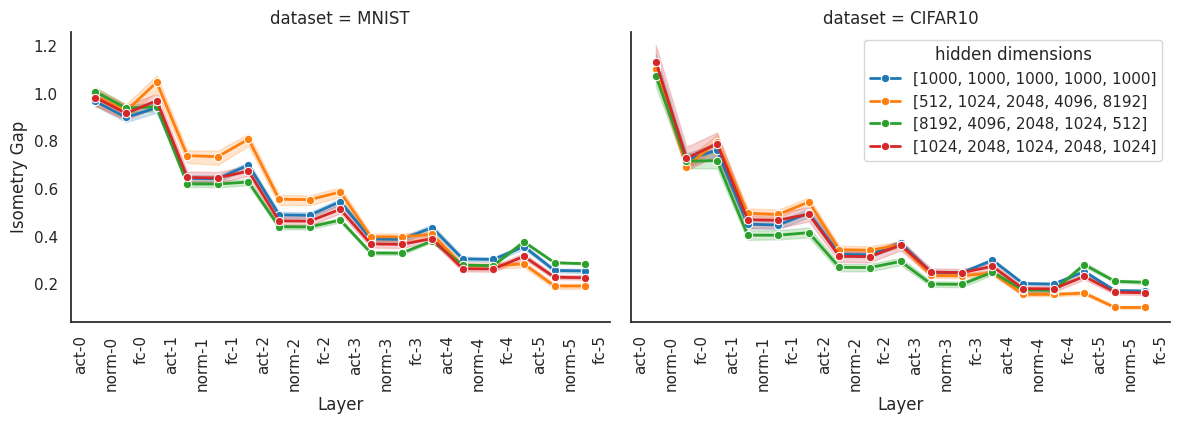

In [4]:
# Define the config grid with lists of possible values for each parameter
config_grid = {
    'model': ['MLP'],
    'dataset': ['MNIST', 'CIFAR10',],
    'hidden_sizes': [[1000,]*5, [int(2**(l+9)) for l in range(5)], [2**(13-l) for l in range(5)], [1024*2**(l%2) for l in range(5)]],
    'conv_channels': [[32, 64, 128, 256]],  # Two convolutional layers with 32 and 64 filters respectively
    'fc_layers': [[512]],  # One fully connected layer for CNN 
    'batch_size': [100],
    'learning_rate': [0.01,],
    'num_epochs': [1],
    'rerun': range(1),
    'activation': ["ReLU"], #["ReLU", "PReLU", "Tanh", "Identity","SELU","SiLU", "ELU", "GELU"],
    'normalization': ["LN",],
}

final_results_df = run_experiment_grid(config_grid)


df = final_results_df
df = df.loc[df.stage=='train']
g = sns.FacetGrid(df, col="dataset", col_wrap=2, height=4, aspect=1.5, hue='mlp_shape', palette="tab10")#, hue_order=activation_beta_df.activation, palette=palette_dict,)
g.map(sns.lineplot, 'layer', 'iso_gap', linewidth=2, marker='o',)
g.set(xlabel='Layer', ylabel='Isometry Gap')
for ax in g.axes.flat:
    ax.set_xticks(df['l'].unique()-.5)
    ax.set_xticklabels(df['layer'].unique(), rotation=90, )

plt.legend(title='hidden dimensions')
plt.savefig('mlp_shape.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# Define the config grid with lists of possible values for each parameter
config_grid = {
    'model': ['MLP'],
    'dataset': ['CIFAR10',],
    'hidden_sizes': [[1000]*10],
    'conv_channels': [[32, 64, 128, 256]],  # Two convolutional layers with 32 and 64 filters respectively
    'fc_layers': [[512]],  # One fully connected layer with 128 units
    'batch_size': [100],
    'learning_rate': [0.01,],
    'num_epochs': [10],
    'rerun': range(1),
    'activation': ["ReLU", "PReLU", "Tanh", "Identity","SELU","SiLU", "ELU", "GELU"],
    'normalization': ["LN",],
}


# final_results_df = run_experiment_grid(config_grid)
final_results_df = pd.read_csv('results_training.csv')


df = final_results_df
df = df.loc[df.stage=='train']
df = df.loc[df.dataset=='CIFAR10']
df = df.loc[df.epoch.isin([0,9])]
df.activation = df.activation.apply(lambda x: x.split(',')[0])
df['activation']  = df.apply(lambda x: f"{x.activation}, $\\beta_0 = {x.beta:.3}$", axis=1)

activation_beta_df = df[['activation', 'beta']].drop_duplicates().sort_values('beta')
colors = sns.color_palette("hot", n_colors=len(activation_beta_df)+5)
palette_dict = {activation: color for activation, color in zip(activation_beta_df['activation'], colors)}
g = sns.FacetGrid(df, col="epoch", col_wrap=2, height=4, aspect=1.4, hue='activation', hue_order=activation_beta_df.activation, palette=palette_dict,)
g.map(sns.lineplot, 'layer', 'iso_gap', linewidth=2).set(yscale = 'log')
# Adding titles and labels
g.set_axis_labels('Layer', 'Isometry Gap')

# Iterate through each facet and set custom xticks
for ax, epoch in zip(g.axes.flat, df.epoch.unique()):
    if epoch==0:
        ax.set_title('CIFAR10, initialization')
    else:
        ax.set_title(f'CIFAR10, epoch {epoch}')
    ax.set_xticks(df['l'].unique()-.5)
    ax.set_xticklabels(df['layer'].unique(), rotation=90, )

    for marker,layer, desc in [('darkgreen','act', 'activation'), ('darkblue','norm', 'normalization')]:#, ('^', 'fc')]:
        df2 = df.loc[df.layer.str.contains(layer)&(df.epoch==epoch)].groupby(['activation', 'l'])['iso_gap'].mean().reset_index()
        for li,l in enumerate(df2.l.unique()):
            if li==0:
                ax.fill_betweenx([0,df.iso_gap.max()], l-1, l, color=marker, alpha=0.2, label=desc)
            else:
                ax.fill_betweenx([0,df.iso_gap.max()], l-1, l, color=marker, alpha=0.2)

ax.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.savefig('iso_gap_int_train.pdf', bbox_inches='tight')
plt.show()

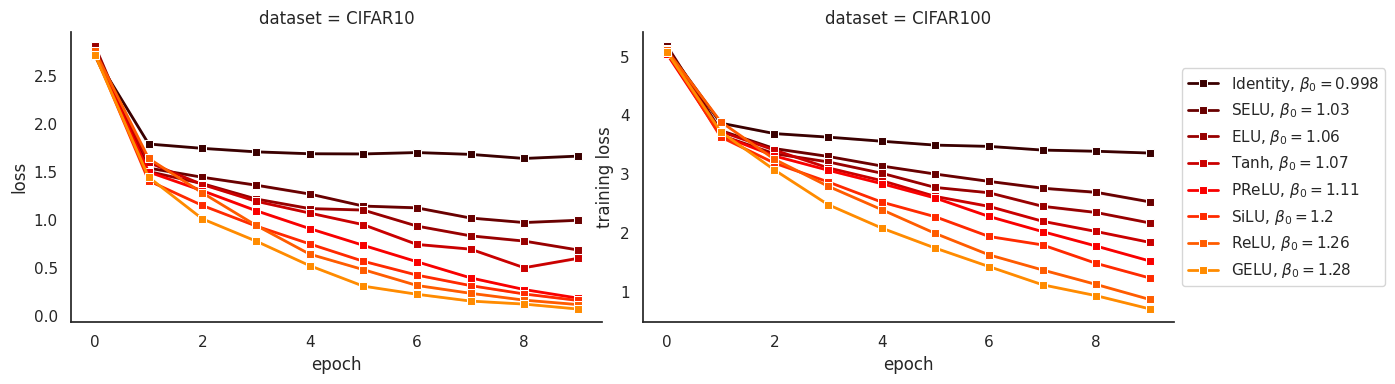

In [4]:
# Define the config grid with lists of possible values for each parameter
config_grid = {
    'model': ['MLP'],
    'dataset': ['CIFAR10','CIFAR100'],
    'hidden_sizes': [[1000]*10],
    'conv_channels': [[32, 64, 128, 256]],  # Two convolutional layers with 32 and 64 filters respectively
    'fc_layers': [[512]],  # One fully connected layer with 128 units
    'batch_size': [512],
    'learning_rate': [0.01,],
    'num_epochs': [10],
    'rerun': range(1),
    'activation': ["ReLU", "Identity","PReLU", "Tanh", "SELU","SiLU", "ELU", "GELU"],
    'normalization': ["LN",],
}


# final_results_df = run_experiment_grid(config_grid)
final_results_df = pd.read_csv('results_training.csv')
# final_results_df.to_csv('results_training.csv')
df = final_results_df
df = df.loc[df.stage=='train'].copy()
df.activation = df.activation.apply(lambda x: x.split(',')[0])
df['activation']  = df.apply(lambda x: f"{x.activation}, $\\beta_0 = {x.beta:.3}$", axis=1)

activation_beta_df = df[['activation', 'beta']].drop_duplicates().sort_values('beta')
colors = sns.color_palette("hot", n_colors=len(activation_beta_df)+5)
palette_dict = {activation: color for activation, color in zip(activation_beta_df['activation'], colors)}
g = sns.FacetGrid(df, col="dataset", col_wrap=2, height=4, aspect=1.5, hue='activation', hue_order=activation_beta_df.activation, palette=palette_dict,sharey=False)
g.map(sns.lineplot, 'epoch', 'loss', linewidth=2, marker='s', )
for ax in g.axes.flat:
    pass
ax.set_ylabel('training loss')
ax.legend(loc='center left', bbox_to_anchor=(1,.5))
plt.savefig('beta0_train_loss.pdf', bbox_inches='tight')
plt.show()

Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 0, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified


Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.42%


 10%|█         | 1/10 [00:08<01:13,  8.18s/it]

Epoch [2/10], Train Loss: 1.9366
Test Accuracy of the model on the 10000 test images: 30.57%


 20%|██        | 2/10 [00:23<01:36, 12.09s/it]

Epoch [3/10], Train Loss: 1.5918
Test Accuracy of the model on the 10000 test images: 33.30%


 30%|███       | 3/10 [00:37<01:33, 13.35s/it]

Epoch [4/10], Train Loss: 1.3622
Test Accuracy of the model on the 10000 test images: 33.62%


 40%|████      | 4/10 [00:52<01:23, 13.99s/it]

Epoch [5/10], Train Loss: 0.9459
Test Accuracy of the model on the 10000 test images: 35.08%


 50%|█████     | 5/10 [01:07<01:11, 14.33s/it]

Epoch [6/10], Train Loss: 0.6747
Test Accuracy of the model on the 10000 test images: 34.59%


 60%|██████    | 6/10 [01:22<00:58, 14.53s/it]

Epoch [7/10], Train Loss: 0.4817
Test Accuracy of the model on the 10000 test images: 34.72%


 70%|███████   | 7/10 [01:37<00:43, 14.63s/it]

Epoch [8/10], Train Loss: 0.3588
Test Accuracy of the model on the 10000 test images: 34.38%


 80%|████████  | 8/10 [01:52<00:29, 14.71s/it]

Epoch [9/10], Train Loss: 0.2182
Test Accuracy of the model on the 10000 test images: 35.35%


 90%|█████████ | 9/10 [02:07<00:14, 14.79s/it]

Epoch [10/10], Train Loss: 0.1877
Test Accuracy of the model on the 10000 test images: 33.61%


100%|██████████| 10/10 [02:22<00:00, 14.23s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 0, 'activation': 'Identity', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.40%


 10%|█         | 1/10 [00:09<01:27,  9.74s/it]

Epoch [2/10], Train Loss: 1.7555
Test Accuracy of the model on the 10000 test images: 36.72%


 20%|██        | 2/10 [00:26<01:49, 13.71s/it]

Epoch [3/10], Train Loss: 1.6821
Test Accuracy of the model on the 10000 test images: 38.00%


 30%|███       | 3/10 [00:42<01:45, 15.02s/it]

Epoch [4/10], Train Loss: 1.6678
Test Accuracy of the model on the 10000 test images: 38.20%


 40%|████      | 4/10 [00:59<01:33, 15.58s/it]

Epoch [5/10], Train Loss: 1.7031
Test Accuracy of the model on the 10000 test images: 39.19%


 50%|█████     | 5/10 [01:15<01:19, 15.89s/it]

Epoch [6/10], Train Loss: 1.7175
Test Accuracy of the model on the 10000 test images: 38.83%


 60%|██████    | 6/10 [01:32<01:04, 16.04s/it]

Epoch [7/10], Train Loss: 1.6458
Test Accuracy of the model on the 10000 test images: 39.19%


 70%|███████   | 7/10 [01:48<00:48, 16.16s/it]

Epoch [8/10], Train Loss: 1.6585
Test Accuracy of the model on the 10000 test images: 38.99%


 80%|████████  | 8/10 [02:04<00:32, 16.24s/it]

Epoch [9/10], Train Loss: 1.7054
Test Accuracy of the model on the 10000 test images: 38.65%


 90%|█████████ | 9/10 [02:21<00:16, 16.27s/it]

Epoch [10/10], Train Loss: 1.6970
Test Accuracy of the model on the 10000 test images: 37.60%


100%|██████████| 10/10 [02:37<00:00, 15.76s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 0, 'activation': 'PReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.00%


 10%|█         | 1/10 [00:08<01:15,  8.41s/it]

Epoch [2/10], Train Loss: 1.6286
Test Accuracy of the model on the 10000 test images: 41.36%


 20%|██        | 2/10 [00:23<01:39, 12.48s/it]

Epoch [3/10], Train Loss: 1.5159
Test Accuracy of the model on the 10000 test images: 43.50%


 30%|███       | 3/10 [00:38<01:36, 13.72s/it]

Epoch [4/10], Train Loss: 1.3343
Test Accuracy of the model on the 10000 test images: 44.10%


 40%|████      | 4/10 [00:54<01:25, 14.30s/it]

Epoch [5/10], Train Loss: 1.1868
Test Accuracy of the model on the 10000 test images: 44.25%


 50%|█████     | 5/10 [01:09<01:13, 14.64s/it]

Epoch [6/10], Train Loss: 0.9429
Test Accuracy of the model on the 10000 test images: 44.49%


 60%|██████    | 6/10 [01:24<00:59, 14.84s/it]

Epoch [7/10], Train Loss: 0.6669
Test Accuracy of the model on the 10000 test images: 44.17%


 70%|███████   | 7/10 [01:39<00:44, 14.94s/it]

Epoch [8/10], Train Loss: 0.5833
Test Accuracy of the model on the 10000 test images: 43.74%


 80%|████████  | 8/10 [01:54<00:30, 15.02s/it]

Epoch [9/10], Train Loss: 0.4864
Test Accuracy of the model on the 10000 test images: 43.10%


 90%|█████████ | 9/10 [02:09<00:15, 15.03s/it]

Epoch [10/10], Train Loss: 0.2981
Test Accuracy of the model on the 10000 test images: 43.32%


100%|██████████| 10/10 [02:25<00:00, 14.51s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 0, 'activation': 'Tanh', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.89%


 10%|█         | 1/10 [00:08<01:16,  8.47s/it]

Epoch [2/10], Train Loss: 1.8080
Test Accuracy of the model on the 10000 test images: 37.63%


 20%|██        | 2/10 [00:23<01:38, 12.31s/it]

Epoch [3/10], Train Loss: 1.6608
Test Accuracy of the model on the 10000 test images: 39.78%


 30%|███       | 3/10 [00:38<01:35, 13.57s/it]

Epoch [4/10], Train Loss: 1.3998
Test Accuracy of the model on the 10000 test images: 40.63%


 40%|████      | 4/10 [00:53<01:24, 14.13s/it]

Epoch [5/10], Train Loss: 1.2380
Test Accuracy of the model on the 10000 test images: 40.91%


 50%|█████     | 5/10 [01:08<01:12, 14.46s/it]

Epoch [6/10], Train Loss: 1.1128
Test Accuracy of the model on the 10000 test images: 40.90%


 60%|██████    | 6/10 [01:23<00:59, 14.75s/it]

Epoch [7/10], Train Loss: 0.9768
Test Accuracy of the model on the 10000 test images: 41.11%


 70%|███████   | 7/10 [01:38<00:44, 14.85s/it]

Epoch [8/10], Train Loss: 0.9180
Test Accuracy of the model on the 10000 test images: 40.90%


 80%|████████  | 8/10 [01:54<00:29, 14.96s/it]

Epoch [9/10], Train Loss: 0.7662
Test Accuracy of the model on the 10000 test images: 40.29%


 90%|█████████ | 9/10 [02:09<00:14, 14.98s/it]

Epoch [10/10], Train Loss: 0.5772
Test Accuracy of the model on the 10000 test images: 41.01%


100%|██████████| 10/10 [02:24<00:00, 14.44s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 0, 'activation': 'SELU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.47%


 10%|█         | 1/10 [00:08<01:19,  8.84s/it]

Epoch [2/10], Train Loss: 1.7314
Test Accuracy of the model on the 10000 test images: 41.70%


 20%|██        | 2/10 [00:24<01:42, 12.79s/it]

Epoch [3/10], Train Loss: 1.5456
Test Accuracy of the model on the 10000 test images: 43.98%


 30%|███       | 3/10 [00:39<01:38, 14.04s/it]

Epoch [4/10], Train Loss: 1.4811
Test Accuracy of the model on the 10000 test images: 45.39%


 40%|████      | 4/10 [00:55<01:28, 14.76s/it]

Epoch [5/10], Train Loss: 1.3916
Test Accuracy of the model on the 10000 test images: 46.04%


 50%|█████     | 5/10 [01:11<01:15, 15.06s/it]

Epoch [6/10], Train Loss: 1.2176
Test Accuracy of the model on the 10000 test images: 47.95%


 60%|██████    | 6/10 [01:27<01:01, 15.38s/it]

Epoch [7/10], Train Loss: 1.1429
Test Accuracy of the model on the 10000 test images: 48.15%


 70%|███████   | 7/10 [01:42<00:46, 15.40s/it]

Epoch [8/10], Train Loss: 1.2384
Test Accuracy of the model on the 10000 test images: 47.41%


 80%|████████  | 8/10 [01:58<00:30, 15.39s/it]

Epoch [9/10], Train Loss: 1.1018
Test Accuracy of the model on the 10000 test images: 48.69%


 90%|█████████ | 9/10 [02:13<00:15, 15.41s/it]

Epoch [10/10], Train Loss: 0.9913
Test Accuracy of the model on the 10000 test images: 48.87%


100%|██████████| 10/10 [02:29<00:00, 14.96s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 0, 'activation': 'SiLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.99%


 10%|█         | 1/10 [00:08<01:15,  8.40s/it]

Epoch [2/10], Train Loss: 1.7639
Test Accuracy of the model on the 10000 test images: 39.07%


 20%|██        | 2/10 [00:23<01:38, 12.37s/it]

Epoch [3/10], Train Loss: 1.4848
Test Accuracy of the model on the 10000 test images: 42.11%


 30%|███       | 3/10 [00:39<01:36, 13.83s/it]

Epoch [4/10], Train Loss: 1.1216
Test Accuracy of the model on the 10000 test images: 43.32%


 40%|████      | 4/10 [00:54<01:26, 14.34s/it]

Epoch [5/10], Train Loss: 0.9646
Test Accuracy of the model on the 10000 test images: 43.54%


 50%|█████     | 5/10 [01:09<01:13, 14.67s/it]

Epoch [6/10], Train Loss: 0.7603
Test Accuracy of the model on the 10000 test images: 43.64%


 60%|██████    | 6/10 [01:24<00:59, 14.84s/it]

Epoch [7/10], Train Loss: 0.6134
Test Accuracy of the model on the 10000 test images: 43.84%


 70%|███████   | 7/10 [01:39<00:44, 14.92s/it]

Epoch [8/10], Train Loss: 0.5067
Test Accuracy of the model on the 10000 test images: 43.24%


 80%|████████  | 8/10 [01:54<00:29, 14.98s/it]

Epoch [9/10], Train Loss: 0.3224
Test Accuracy of the model on the 10000 test images: 44.01%


 90%|█████████ | 9/10 [02:10<00:15, 15.03s/it]

Epoch [10/10], Train Loss: 0.2255
Test Accuracy of the model on the 10000 test images: 43.79%


100%|██████████| 10/10 [02:25<00:00, 14.51s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 0, 'activation': 'ELU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.34%


 10%|█         | 1/10 [00:08<01:17,  8.57s/it]

Epoch [2/10], Train Loss: 1.6210
Test Accuracy of the model on the 10000 test images: 42.95%


 20%|██        | 2/10 [00:23<01:39, 12.49s/it]

Epoch [3/10], Train Loss: 1.4267
Test Accuracy of the model on the 10000 test images: 45.42%


 30%|███       | 3/10 [00:39<01:36, 13.77s/it]

Epoch [4/10], Train Loss: 1.3034
Test Accuracy of the model on the 10000 test images: 47.05%


 40%|████      | 4/10 [00:54<01:27, 14.54s/it]

Epoch [5/10], Train Loss: 1.1961
Test Accuracy of the model on the 10000 test images: 48.31%


 50%|█████     | 5/10 [01:10<01:14, 14.81s/it]

Epoch [6/10], Train Loss: 1.1885
Test Accuracy of the model on the 10000 test images: 47.21%


 60%|██████    | 6/10 [01:25<00:59, 14.98s/it]

Epoch [7/10], Train Loss: 1.0694
Test Accuracy of the model on the 10000 test images: 48.75%


 70%|███████   | 7/10 [01:40<00:45, 15.09s/it]

Epoch [8/10], Train Loss: 0.9901
Test Accuracy of the model on the 10000 test images: 48.75%


 80%|████████  | 8/10 [01:56<00:30, 15.26s/it]

Epoch [9/10], Train Loss: 0.7996
Test Accuracy of the model on the 10000 test images: 49.33%


 90%|█████████ | 9/10 [02:11<00:15, 15.31s/it]

Epoch [10/10], Train Loss: 0.6870
Test Accuracy of the model on the 10000 test images: 48.44%


100%|██████████| 10/10 [02:27<00:00, 14.72s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 0, 'activation': 'GELU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.09%


 10%|█         | 1/10 [00:08<01:15,  8.34s/it]

Epoch [2/10], Train Loss: 1.8617
Test Accuracy of the model on the 10000 test images: 33.80%


 20%|██        | 2/10 [00:23<01:38, 12.31s/it]

Epoch [3/10], Train Loss: 1.3882
Test Accuracy of the model on the 10000 test images: 36.33%


 30%|███       | 3/10 [00:38<01:34, 13.50s/it]

Epoch [4/10], Train Loss: 1.0764
Test Accuracy of the model on the 10000 test images: 37.05%


 40%|████      | 4/10 [00:53<01:24, 14.02s/it]

Epoch [5/10], Train Loss: 0.7480
Test Accuracy of the model on the 10000 test images: 37.65%


 50%|█████     | 5/10 [01:07<01:11, 14.31s/it]

Epoch [6/10], Train Loss: 0.5003
Test Accuracy of the model on the 10000 test images: 37.69%


 60%|██████    | 6/10 [01:23<00:58, 14.59s/it]

Epoch [7/10], Train Loss: 0.3403
Test Accuracy of the model on the 10000 test images: 37.61%


 70%|███████   | 7/10 [01:38<00:44, 14.73s/it]

Epoch [8/10], Train Loss: 0.2726
Test Accuracy of the model on the 10000 test images: 37.11%


 80%|████████  | 8/10 [01:53<00:29, 14.85s/it]

Epoch [9/10], Train Loss: 0.1961
Test Accuracy of the model on the 10000 test images: 37.73%


 90%|█████████ | 9/10 [02:08<00:14, 14.94s/it]

Epoch [10/10], Train Loss: 0.1036
Test Accuracy of the model on the 10000 test images: 37.70%


100%|██████████| 10/10 [02:23<00:00, 14.35s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 1, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.95%


 10%|█         | 1/10 [00:08<01:14,  8.27s/it]

Epoch [2/10], Train Loss: 1.9849
Test Accuracy of the model on the 10000 test images: 29.33%


 20%|██        | 2/10 [00:23<01:37, 12.24s/it]

Epoch [3/10], Train Loss: 1.7238
Test Accuracy of the model on the 10000 test images: 32.64%


 30%|███       | 3/10 [00:38<01:34, 13.44s/it]

Epoch [4/10], Train Loss: 1.2221
Test Accuracy of the model on the 10000 test images: 33.84%


 40%|████      | 4/10 [00:53<01:24, 14.04s/it]

Epoch [5/10], Train Loss: 0.9167
Test Accuracy of the model on the 10000 test images: 34.38%


 50%|█████     | 5/10 [01:08<01:12, 14.42s/it]

Epoch [6/10], Train Loss: 0.7040
Test Accuracy of the model on the 10000 test images: 33.93%


 60%|██████    | 6/10 [01:23<00:58, 14.60s/it]

Epoch [7/10], Train Loss: 0.4309
Test Accuracy of the model on the 10000 test images: 34.42%


 70%|███████   | 7/10 [01:38<00:44, 14.73s/it]

Epoch [8/10], Train Loss: 0.3953
Test Accuracy of the model on the 10000 test images: 33.25%


 80%|████████  | 8/10 [01:53<00:29, 14.84s/it]

Epoch [9/10], Train Loss: 0.1843
Test Accuracy of the model on the 10000 test images: 35.07%


 90%|█████████ | 9/10 [02:08<00:14, 14.92s/it]

Epoch [10/10], Train Loss: 0.1630
Test Accuracy of the model on the 10000 test images: 34.76%


100%|██████████| 10/10 [02:23<00:00, 14.33s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 1, 'activation': 'Identity', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.90%


 10%|█         | 1/10 [00:09<01:27,  9.77s/it]

Epoch [2/10], Train Loss: 1.8790
Test Accuracy of the model on the 10000 test images: 35.48%


 20%|██        | 2/10 [00:26<01:50, 13.76s/it]

Epoch [3/10], Train Loss: 1.7240
Test Accuracy of the model on the 10000 test images: 38.31%


 30%|███       | 3/10 [00:42<01:45, 15.04s/it]

Epoch [4/10], Train Loss: 1.7100
Test Accuracy of the model on the 10000 test images: 38.68%


 40%|████      | 4/10 [00:59<01:33, 15.58s/it]

Epoch [5/10], Train Loss: 1.7842
Test Accuracy of the model on the 10000 test images: 38.07%


 50%|█████     | 5/10 [01:15<01:19, 15.88s/it]

Epoch [6/10], Train Loss: 1.8007
Test Accuracy of the model on the 10000 test images: 38.51%


 60%|██████    | 6/10 [01:32<01:04, 16.05s/it]

Epoch [7/10], Train Loss: 1.7421
Test Accuracy of the model on the 10000 test images: 38.49%


 70%|███████   | 7/10 [01:48<00:48, 16.17s/it]

Epoch [8/10], Train Loss: 1.8152
Test Accuracy of the model on the 10000 test images: 38.75%


 80%|████████  | 8/10 [02:04<00:32, 16.20s/it]

Epoch [9/10], Train Loss: 1.5901
Test Accuracy of the model on the 10000 test images: 38.76%


 90%|█████████ | 9/10 [02:21<00:16, 16.23s/it]

Epoch [10/10], Train Loss: 1.6454
Test Accuracy of the model on the 10000 test images: 38.65%


100%|██████████| 10/10 [02:37<00:00, 15.77s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 1, 'activation': 'PReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.94%


 10%|█         | 1/10 [00:08<01:16,  8.47s/it]

Epoch [2/10], Train Loss: 1.6474
Test Accuracy of the model on the 10000 test images: 41.04%


 20%|██        | 2/10 [00:23<01:39, 12.47s/it]

Epoch [3/10], Train Loss: 1.4290
Test Accuracy of the model on the 10000 test images: 43.79%


 30%|███       | 3/10 [00:38<01:36, 13.73s/it]

Epoch [4/10], Train Loss: 1.2319
Test Accuracy of the model on the 10000 test images: 45.48%


 40%|████      | 4/10 [00:54<01:25, 14.33s/it]

Epoch [5/10], Train Loss: 1.0722
Test Accuracy of the model on the 10000 test images: 46.12%


 50%|█████     | 5/10 [01:09<01:13, 14.60s/it]

Epoch [6/10], Train Loss: 0.9906
Test Accuracy of the model on the 10000 test images: 45.08%


 60%|██████    | 6/10 [01:24<00:59, 14.87s/it]

Epoch [7/10], Train Loss: 0.7493
Test Accuracy of the model on the 10000 test images: 45.18%


 70%|███████   | 7/10 [01:39<00:45, 15.01s/it]

Epoch [8/10], Train Loss: 0.6328
Test Accuracy of the model on the 10000 test images: 43.97%


 80%|████████  | 8/10 [01:55<00:30, 15.13s/it]

Epoch [9/10], Train Loss: 0.3959
Test Accuracy of the model on the 10000 test images: 44.47%


 90%|█████████ | 9/10 [02:10<00:15, 15.24s/it]

Epoch [10/10], Train Loss: 0.2513
Test Accuracy of the model on the 10000 test images: 44.73%


100%|██████████| 10/10 [02:26<00:00, 14.62s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 1, 'activation': 'Tanh', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.43%


 10%|█         | 1/10 [00:08<01:16,  8.55s/it]

Epoch [2/10], Train Loss: 1.8016
Test Accuracy of the model on the 10000 test images: 36.41%


 20%|██        | 2/10 [00:23<01:39, 12.39s/it]

Epoch [3/10], Train Loss: 1.5518
Test Accuracy of the model on the 10000 test images: 39.88%


 30%|███       | 3/10 [00:38<01:35, 13.71s/it]

Epoch [4/10], Train Loss: 1.4738
Test Accuracy of the model on the 10000 test images: 40.60%


 40%|████      | 4/10 [00:53<01:25, 14.23s/it]

Epoch [5/10], Train Loss: 1.1798
Test Accuracy of the model on the 10000 test images: 41.10%


 50%|█████     | 5/10 [01:08<01:12, 14.52s/it]

Epoch [6/10], Train Loss: 1.1445
Test Accuracy of the model on the 10000 test images: 41.33%


 60%|██████    | 6/10 [01:24<00:59, 14.81s/it]

Epoch [7/10], Train Loss: 0.9228
Test Accuracy of the model on the 10000 test images: 41.33%


 70%|███████   | 7/10 [01:39<00:45, 15.01s/it]

Epoch [8/10], Train Loss: 0.8669
Test Accuracy of the model on the 10000 test images: 39.62%


 80%|████████  | 8/10 [01:54<00:30, 15.07s/it]

Epoch [9/10], Train Loss: 0.7299
Test Accuracy of the model on the 10000 test images: 41.52%


 90%|█████████ | 9/10 [02:10<00:15, 15.13s/it]

Epoch [10/10], Train Loss: 0.7261
Test Accuracy of the model on the 10000 test images: 39.56%


100%|██████████| 10/10 [02:25<00:00, 14.55s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 1, 'activation': 'SELU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.11%


 10%|█         | 1/10 [00:08<01:19,  8.81s/it]

Epoch [2/10], Train Loss: 1.7155
Test Accuracy of the model on the 10000 test images: 41.57%


 20%|██        | 2/10 [00:24<01:42, 12.83s/it]

Epoch [3/10], Train Loss: 1.5198
Test Accuracy of the model on the 10000 test images: 44.03%


 30%|███       | 3/10 [00:39<01:38, 14.05s/it]

Epoch [4/10], Train Loss: 1.4060
Test Accuracy of the model on the 10000 test images: 45.28%


 40%|████      | 4/10 [00:55<01:27, 14.61s/it]

Epoch [5/10], Train Loss: 1.3367
Test Accuracy of the model on the 10000 test images: 46.02%


 50%|█████     | 5/10 [01:11<01:14, 14.96s/it]

Epoch [6/10], Train Loss: 1.2932
Test Accuracy of the model on the 10000 test images: 47.40%


 60%|██████    | 6/10 [01:26<01:00, 15.19s/it]

Epoch [7/10], Train Loss: 1.2110
Test Accuracy of the model on the 10000 test images: 47.41%


 70%|███████   | 7/10 [01:42<00:45, 15.30s/it]

Epoch [8/10], Train Loss: 1.2410
Test Accuracy of the model on the 10000 test images: 46.92%


 80%|████████  | 8/10 [01:57<00:30, 15.36s/it]

Epoch [9/10], Train Loss: 0.9937
Test Accuracy of the model on the 10000 test images: 48.20%


 90%|█████████ | 9/10 [02:13<00:15, 15.40s/it]

Epoch [10/10], Train Loss: 0.8801
Test Accuracy of the model on the 10000 test images: 47.66%


100%|██████████| 10/10 [02:28<00:00, 14.87s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 1, 'activation': 'SiLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.80%


 10%|█         | 1/10 [00:08<01:15,  8.34s/it]

Epoch [2/10], Train Loss: 1.7769
Test Accuracy of the model on the 10000 test images: 38.75%


 20%|██        | 2/10 [00:23<01:39, 12.38s/it]

Epoch [3/10], Train Loss: 1.4710
Test Accuracy of the model on the 10000 test images: 41.36%


 30%|███       | 3/10 [00:38<01:35, 13.69s/it]

Epoch [4/10], Train Loss: 1.2377
Test Accuracy of the model on the 10000 test images: 43.17%


 40%|████      | 4/10 [00:53<01:25, 14.25s/it]

Epoch [5/10], Train Loss: 1.0918
Test Accuracy of the model on the 10000 test images: 43.72%


 50%|█████     | 5/10 [01:09<01:12, 14.56s/it]

Epoch [6/10], Train Loss: 0.7749
Test Accuracy of the model on the 10000 test images: 43.63%


 60%|██████    | 6/10 [01:23<00:58, 14.69s/it]

Epoch [7/10], Train Loss: 0.5493
Test Accuracy of the model on the 10000 test images: 44.15%


 70%|███████   | 7/10 [01:38<00:44, 14.77s/it]

Epoch [8/10], Train Loss: 0.4541
Test Accuracy of the model on the 10000 test images: 43.24%


 80%|████████  | 8/10 [01:53<00:29, 14.83s/it]

Epoch [9/10], Train Loss: 0.3516
Test Accuracy of the model on the 10000 test images: 44.43%


 90%|█████████ | 9/10 [02:08<00:14, 14.91s/it]

Epoch [10/10], Train Loss: 0.2418
Test Accuracy of the model on the 10000 test images: 43.26%


100%|██████████| 10/10 [02:24<00:00, 14.41s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 1, 'activation': 'ELU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.06%


 10%|█         | 1/10 [00:08<01:17,  8.67s/it]

Epoch [2/10], Train Loss: 1.5681
Test Accuracy of the model on the 10000 test images: 43.28%


 20%|██        | 2/10 [00:24<01:41, 12.74s/it]

Epoch [3/10], Train Loss: 1.4475
Test Accuracy of the model on the 10000 test images: 45.75%


 30%|███       | 3/10 [00:39<01:37, 13.98s/it]

Epoch [4/10], Train Loss: 1.2748
Test Accuracy of the model on the 10000 test images: 47.40%


 40%|████      | 4/10 [00:55<01:27, 14.54s/it]

Epoch [5/10], Train Loss: 1.2319
Test Accuracy of the model on the 10000 test images: 47.20%


 50%|█████     | 5/10 [01:10<01:14, 14.85s/it]

Epoch [6/10], Train Loss: 1.1015
Test Accuracy of the model on the 10000 test images: 48.73%


 60%|██████    | 6/10 [01:25<01:00, 15.06s/it]

Epoch [7/10], Train Loss: 1.0718
Test Accuracy of the model on the 10000 test images: 48.65%


 70%|███████   | 7/10 [01:41<00:45, 15.19s/it]

Epoch [8/10], Train Loss: 0.9668
Test Accuracy of the model on the 10000 test images: 48.99%


 80%|████████  | 8/10 [01:56<00:30, 15.25s/it]

Epoch [9/10], Train Loss: 0.9973
Test Accuracy of the model on the 10000 test images: 48.58%


 90%|█████████ | 9/10 [02:12<00:15, 15.33s/it]

Epoch [10/10], Train Loss: 0.8439
Test Accuracy of the model on the 10000 test images: 48.13%


100%|██████████| 10/10 [02:27<00:00, 14.75s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 1, 'activation': 'GELU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.05%


 10%|█         | 1/10 [00:08<01:14,  8.24s/it]

Epoch [2/10], Train Loss: 1.8052
Test Accuracy of the model on the 10000 test images: 34.54%


 20%|██        | 2/10 [00:23<01:36, 12.11s/it]

Epoch [3/10], Train Loss: 1.4399
Test Accuracy of the model on the 10000 test images: 35.93%


 30%|███       | 3/10 [00:37<01:33, 13.37s/it]

Epoch [4/10], Train Loss: 1.0478
Test Accuracy of the model on the 10000 test images: 37.60%


 40%|████      | 4/10 [00:52<01:23, 13.99s/it]

Epoch [5/10], Train Loss: 0.8165
Test Accuracy of the model on the 10000 test images: 37.89%


 50%|█████     | 5/10 [01:07<01:11, 14.35s/it]

Epoch [6/10], Train Loss: 0.5273
Test Accuracy of the model on the 10000 test images: 37.80%


 60%|██████    | 6/10 [01:22<00:58, 14.56s/it]

Epoch [7/10], Train Loss: 0.3384
Test Accuracy of the model on the 10000 test images: 37.87%


 70%|███████   | 7/10 [01:37<00:44, 14.70s/it]

Epoch [8/10], Train Loss: 0.2488
Test Accuracy of the model on the 10000 test images: 37.81%


 80%|████████  | 8/10 [01:52<00:29, 14.76s/it]

Epoch [9/10], Train Loss: 0.1938
Test Accuracy of the model on the 10000 test images: 37.56%


 90%|█████████ | 9/10 [02:07<00:14, 14.81s/it]

Epoch [10/10], Train Loss: 0.0933
Test Accuracy of the model on the 10000 test images: 38.09%


100%|██████████| 10/10 [02:22<00:00, 14.25s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 2, 'activation': 'ReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.03%


 10%|█         | 1/10 [00:08<01:14,  8.23s/it]

Epoch [2/10], Train Loss: 2.1025
Test Accuracy of the model on the 10000 test images: 29.99%


 20%|██        | 2/10 [00:23<01:36, 12.11s/it]

Epoch [3/10], Train Loss: 1.7035
Test Accuracy of the model on the 10000 test images: 33.03%


 30%|███       | 3/10 [00:37<01:33, 13.35s/it]

Epoch [4/10], Train Loss: 1.2899
Test Accuracy of the model on the 10000 test images: 34.10%


 40%|████      | 4/10 [00:52<01:23, 13.96s/it]

Epoch [5/10], Train Loss: 0.9993
Test Accuracy of the model on the 10000 test images: 33.82%


 50%|█████     | 5/10 [01:07<01:11, 14.31s/it]

Epoch [6/10], Train Loss: 0.7209
Test Accuracy of the model on the 10000 test images: 34.47%


 60%|██████    | 6/10 [01:22<00:58, 14.51s/it]

Epoch [7/10], Train Loss: 0.4659
Test Accuracy of the model on the 10000 test images: 34.22%


 70%|███████   | 7/10 [01:37<00:43, 14.64s/it]

Epoch [8/10], Train Loss: 0.3148
Test Accuracy of the model on the 10000 test images: 33.94%


 80%|████████  | 8/10 [01:52<00:29, 14.73s/it]

Epoch [9/10], Train Loss: 0.2130
Test Accuracy of the model on the 10000 test images: 33.60%


 90%|█████████ | 9/10 [02:07<00:14, 14.75s/it]

Epoch [10/10], Train Loss: 0.1457
Test Accuracy of the model on the 10000 test images: 34.32%


100%|██████████| 10/10 [02:22<00:00, 14.20s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 2, 'activation': 'Identity', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 8.87%


 10%|█         | 1/10 [00:09<01:27,  9.70s/it]

Epoch [2/10], Train Loss: 1.6532
Test Accuracy of the model on the 10000 test images: 36.91%


 20%|██        | 2/10 [00:26<01:48, 13.62s/it]

Epoch [3/10], Train Loss: 1.7593
Test Accuracy of the model on the 10000 test images: 37.25%


 30%|███       | 3/10 [00:42<01:43, 14.85s/it]

Epoch [4/10], Train Loss: 1.7408
Test Accuracy of the model on the 10000 test images: 37.66%


 40%|████      | 4/10 [00:58<01:32, 15.45s/it]

Epoch [5/10], Train Loss: 1.7364
Test Accuracy of the model on the 10000 test images: 38.42%


 50%|█████     | 5/10 [01:14<01:18, 15.73s/it]

Epoch [6/10], Train Loss: 1.6692
Test Accuracy of the model on the 10000 test images: 38.62%


 60%|██████    | 6/10 [01:31<01:03, 15.95s/it]

Epoch [7/10], Train Loss: 1.7611
Test Accuracy of the model on the 10000 test images: 39.20%


 70%|███████   | 7/10 [01:47<00:48, 16.12s/it]

Epoch [8/10], Train Loss: 1.5945
Test Accuracy of the model on the 10000 test images: 39.20%


 80%|████████  | 8/10 [02:04<00:32, 16.24s/it]

Epoch [9/10], Train Loss: 1.6584
Test Accuracy of the model on the 10000 test images: 38.53%


 90%|█████████ | 9/10 [02:20<00:16, 16.29s/it]

Epoch [10/10], Train Loss: 1.5775
Test Accuracy of the model on the 10000 test images: 39.84%


100%|██████████| 10/10 [02:37<00:00, 15.72s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 2, 'activation': 'PReLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.10%


 10%|█         | 1/10 [00:08<01:16,  8.48s/it]

Epoch [2/10], Train Loss: 1.6555
Test Accuracy of the model on the 10000 test images: 40.61%


 20%|██        | 2/10 [00:23<01:40, 12.57s/it]

Epoch [3/10], Train Loss: 1.4454
Test Accuracy of the model on the 10000 test images: 42.60%


 30%|███       | 3/10 [00:39<01:36, 13.79s/it]

Epoch [4/10], Train Loss: 1.2653
Test Accuracy of the model on the 10000 test images: 44.92%


 40%|████      | 4/10 [00:54<01:26, 14.36s/it]

Epoch [5/10], Train Loss: 1.2705
Test Accuracy of the model on the 10000 test images: 45.37%


 50%|█████     | 5/10 [01:11<01:17, 15.43s/it]

Epoch [6/10], Train Loss: 0.9165
Test Accuracy of the model on the 10000 test images: 45.84%


 60%|██████    | 6/10 [01:32<01:08, 17.16s/it]

Epoch [7/10], Train Loss: 0.8565
Test Accuracy of the model on the 10000 test images: 44.78%


 70%|███████   | 7/10 [01:47<00:49, 16.51s/it]

Epoch [8/10], Train Loss: 0.6043
Test Accuracy of the model on the 10000 test images: 45.20%


 80%|████████  | 8/10 [02:02<00:32, 16.06s/it]

Epoch [9/10], Train Loss: 0.4518
Test Accuracy of the model on the 10000 test images: 44.59%


 90%|█████████ | 9/10 [02:17<00:15, 15.81s/it]

Epoch [10/10], Train Loss: 0.2836
Test Accuracy of the model on the 10000 test images: 45.27%


100%|██████████| 10/10 [02:32<00:00, 15.29s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 2, 'activation': 'Tanh', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.70%


 10%|█         | 1/10 [00:08<01:16,  8.51s/it]

Epoch [2/10], Train Loss: 1.7976
Test Accuracy of the model on the 10000 test images: 36.11%


 20%|██        | 2/10 [00:23<01:39, 12.45s/it]

Epoch [3/10], Train Loss: 1.5446
Test Accuracy of the model on the 10000 test images: 39.43%


 30%|███       | 3/10 [00:39<01:36, 13.76s/it]

Epoch [4/10], Train Loss: 1.4153
Test Accuracy of the model on the 10000 test images: 40.08%


 40%|████      | 4/10 [00:54<01:26, 14.40s/it]

Epoch [5/10], Train Loss: 1.2479
Test Accuracy of the model on the 10000 test images: 40.65%


 50%|█████     | 5/10 [01:09<01:13, 14.73s/it]

Epoch [6/10], Train Loss: 1.1956
Test Accuracy of the model on the 10000 test images: 40.17%


 60%|██████    | 6/10 [01:24<00:59, 14.88s/it]

Epoch [7/10], Train Loss: 1.0753
Test Accuracy of the model on the 10000 test images: 39.90%


 70%|███████   | 7/10 [01:40<00:44, 14.96s/it]

Epoch [8/10], Train Loss: 0.7909
Test Accuracy of the model on the 10000 test images: 40.67%


 80%|████████  | 8/10 [01:55<00:30, 15.05s/it]

Epoch [9/10], Train Loss: 0.7326
Test Accuracy of the model on the 10000 test images: 38.76%


 90%|█████████ | 9/10 [02:10<00:15, 15.07s/it]

Epoch [10/10], Train Loss: 0.6208
Test Accuracy of the model on the 10000 test images: 40.86%


100%|██████████| 10/10 [02:25<00:00, 14.55s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 2, 'activation': 'SELU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.13%


 10%|█         | 1/10 [00:08<01:19,  8.83s/it]

Epoch [2/10], Train Loss: 1.7058
Test Accuracy of the model on the 10000 test images: 40.84%


 20%|██        | 2/10 [00:24<01:42, 12.85s/it]

Epoch [3/10], Train Loss: 1.6050
Test Accuracy of the model on the 10000 test images: 44.20%


 30%|███       | 3/10 [00:40<01:38, 14.08s/it]

Epoch [4/10], Train Loss: 1.3690
Test Accuracy of the model on the 10000 test images: 46.52%


 40%|████      | 4/10 [00:55<01:28, 14.69s/it]

Epoch [5/10], Train Loss: 1.2516
Test Accuracy of the model on the 10000 test images: 46.64%


 50%|█████     | 5/10 [01:11<01:14, 14.99s/it]

Epoch [6/10], Train Loss: 1.3112
Test Accuracy of the model on the 10000 test images: 47.99%


 60%|██████    | 6/10 [01:27<01:01, 15.27s/it]

Epoch [7/10], Train Loss: 1.2291
Test Accuracy of the model on the 10000 test images: 47.69%


 70%|███████   | 7/10 [01:42<00:46, 15.38s/it]

Epoch [8/10], Train Loss: 1.1929
Test Accuracy of the model on the 10000 test images: 47.76%


 80%|████████  | 8/10 [01:58<00:30, 15.45s/it]

Epoch [9/10], Train Loss: 1.1125
Test Accuracy of the model on the 10000 test images: 48.45%


 90%|█████████ | 9/10 [02:13<00:15, 15.50s/it]

Epoch [10/10], Train Loss: 1.0409
Test Accuracy of the model on the 10000 test images: 48.16%


100%|██████████| 10/10 [02:29<00:00, 14.94s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 2, 'activation': 'SiLU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.58%


 10%|█         | 1/10 [00:08<01:15,  8.35s/it]

Epoch [2/10], Train Loss: 1.7981
Test Accuracy of the model on the 10000 test images: 38.50%


 20%|██        | 2/10 [00:23<01:38, 12.31s/it]

Epoch [3/10], Train Loss: 1.5027
Test Accuracy of the model on the 10000 test images: 40.54%


 30%|███       | 3/10 [00:38<01:34, 13.52s/it]

Epoch [4/10], Train Loss: 1.1668
Test Accuracy of the model on the 10000 test images: 42.80%


 40%|████      | 4/10 [00:53<01:25, 14.19s/it]

Epoch [5/10], Train Loss: 0.9624
Test Accuracy of the model on the 10000 test images: 42.80%


 50%|█████     | 5/10 [01:08<01:12, 14.55s/it]

Epoch [6/10], Train Loss: 0.7721
Test Accuracy of the model on the 10000 test images: 43.76%


 60%|██████    | 6/10 [01:23<00:58, 14.72s/it]

Epoch [7/10], Train Loss: 0.5810
Test Accuracy of the model on the 10000 test images: 43.28%


 70%|███████   | 7/10 [01:38<00:44, 14.81s/it]

Epoch [8/10], Train Loss: 0.4704
Test Accuracy of the model on the 10000 test images: 43.32%


 80%|████████  | 8/10 [01:53<00:29, 14.87s/it]

Epoch [9/10], Train Loss: 0.3310
Test Accuracy of the model on the 10000 test images: 43.35%


 90%|█████████ | 9/10 [02:09<00:14, 14.97s/it]

Epoch [10/10], Train Loss: 0.1972
Test Accuracy of the model on the 10000 test images: 43.36%


100%|██████████| 10/10 [02:24<00:00, 14.41s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 2, 'activation': 'ELU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 9.26%


 10%|█         | 1/10 [00:08<01:18,  8.67s/it]

Epoch [2/10], Train Loss: 1.6164
Test Accuracy of the model on the 10000 test images: 41.81%


 20%|██        | 2/10 [00:24<01:41, 12.71s/it]

Epoch [3/10], Train Loss: 1.3866
Test Accuracy of the model on the 10000 test images: 44.83%


 30%|███       | 3/10 [00:39<01:37, 13.93s/it]

Epoch [4/10], Train Loss: 1.4395
Test Accuracy of the model on the 10000 test images: 46.77%


 40%|████      | 4/10 [00:54<01:26, 14.48s/it]

Epoch [5/10], Train Loss: 1.3140
Test Accuracy of the model on the 10000 test images: 47.50%


 50%|█████     | 5/10 [01:10<01:13, 14.75s/it]

Epoch [6/10], Train Loss: 1.1534
Test Accuracy of the model on the 10000 test images: 49.19%


 60%|██████    | 6/10 [01:25<00:59, 14.96s/it]

Epoch [7/10], Train Loss: 0.9990
Test Accuracy of the model on the 10000 test images: 49.32%


 70%|███████   | 7/10 [01:40<00:45, 15.06s/it]

Epoch [8/10], Train Loss: 1.0598
Test Accuracy of the model on the 10000 test images: 49.13%


 80%|████████  | 8/10 [01:56<00:30, 15.12s/it]

Epoch [9/10], Train Loss: 0.8321
Test Accuracy of the model on the 10000 test images: 49.40%


 90%|█████████ | 9/10 [02:11<00:15, 15.18s/it]

Epoch [10/10], Train Loss: 0.8669
Test Accuracy of the model on the 10000 test images: 48.20%


100%|██████████| 10/10 [02:26<00:00, 14.69s/it]


Running experiment for config: {'model': 'MLP', 'dataset': 'CIFAR10', 'hidden_sizes': [1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], 'batch_size': 512, 'learning_rate': 0.01, 'num_epochs': 10, 'rerun': 2, 'activation': 'GELU', 'normalization': 'LN'}
Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/10 [00:00<?, ?it/s]

Test Accuracy of the model on the 10000 test images: 10.30%


 10%|█         | 1/10 [00:08<01:14,  8.24s/it]

Epoch [2/10], Train Loss: 1.9507
Test Accuracy of the model on the 10000 test images: 34.19%


 20%|██        | 2/10 [00:23<01:37, 12.13s/it]

Epoch [3/10], Train Loss: 1.4068
Test Accuracy of the model on the 10000 test images: 36.61%


 30%|███       | 3/10 [00:38<01:34, 13.44s/it]

Epoch [4/10], Train Loss: 1.0742
Test Accuracy of the model on the 10000 test images: 37.45%


 40%|████      | 4/10 [00:53<01:24, 14.04s/it]

Epoch [5/10], Train Loss: 0.8393
Test Accuracy of the model on the 10000 test images: 37.48%


 50%|█████     | 5/10 [01:08<01:11, 14.39s/it]

Epoch [6/10], Train Loss: 0.4948
Test Accuracy of the model on the 10000 test images: 37.71%


 60%|██████    | 6/10 [01:23<00:58, 14.59s/it]

Epoch [7/10], Train Loss: 0.4043
Test Accuracy of the model on the 10000 test images: 37.34%


 70%|███████   | 7/10 [01:38<00:44, 14.75s/it]

Epoch [8/10], Train Loss: 0.2700
Test Accuracy of the model on the 10000 test images: 37.03%


 80%|████████  | 8/10 [01:53<00:29, 14.91s/it]

Epoch [9/10], Train Loss: 0.1514
Test Accuracy of the model on the 10000 test images: 37.47%


 90%|█████████ | 9/10 [02:08<00:14, 14.99s/it]

Epoch [10/10], Train Loss: 0.1199
Test Accuracy of the model on the 10000 test images: 37.64%


100%|██████████| 10/10 [02:23<00:00, 14.37s/it]


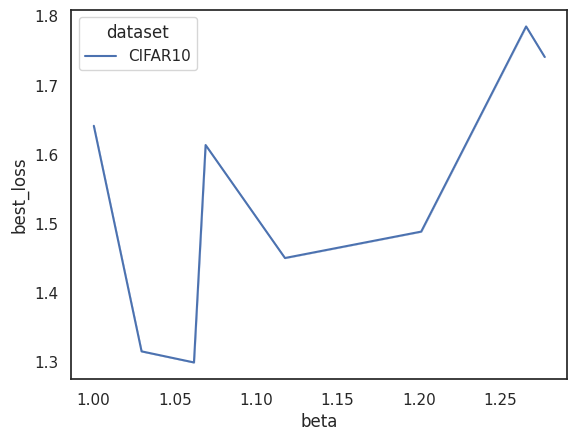

In [27]:
# Define the config grid with lists of possible values for each parameter
config_grid = {
    'model': ['MLP'],
    'dataset': ['CIFAR10',],
    'hidden_sizes': [[1000]*10],
    'batch_size': [512],
    'learning_rate': [0.01,],
    'num_epochs': [10],
    'rerun': range(3),
    'activation': ["ReLU", "Identity","PReLU", "Tanh", "SELU","SiLU", "ELU", "GELU"],
    'normalization': ["LN",],
}


final_results_df = run_experiment_grid(config_grid)
df = final_results_df
df = df.loc[df.stage=='test']


sns.lineplot(df, x='beta', y='best_loss', hue='dataset')
plt.show()

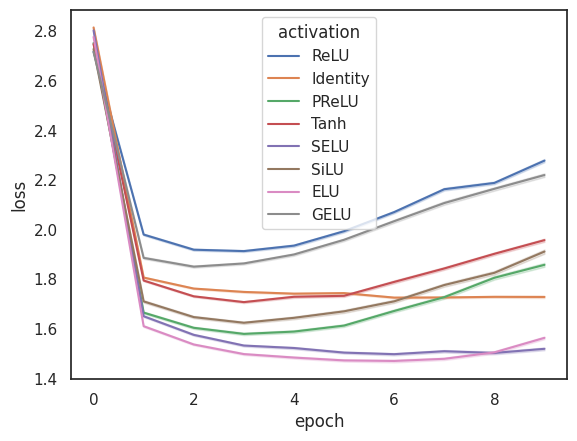

In [28]:
sns.lineplot(df, x='epoch', y='loss', hue='activation')
plt.show()

<ipython-input-37-416a3d52fc83>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(df.groupby(['beta', 'best_loss', 'dataset']).median().reset_index(), x='beta', y='best_loss', hue='dataset')


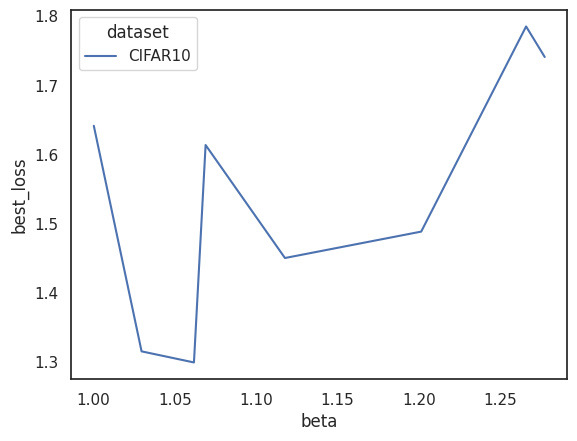

In [37]:
df2 = df.groupby(['activation', 'dataset'])['loss'].min().reset_index()
df2 = df2.rename(columns={'loss': 'best_loss'})
df = df.merge(df2, on=['activation', 'dataset'])

sns.lineplot(df.groupby(['beta', 'best_loss', 'dataset']).median().reset_index(), x='beta', y='best_loss', hue='dataset')
plt.show()

In [31]:
df2

,activation,dataset,best_loss
0,ELU,CIFAR10,1.424544
1,GELU,CIFAR10,1.831653
2,Identity,CIFAR10,1.692156
3,PReLU,CIFAR10,1.549974
4,ReLU,CIFAR10,1.893809
5,SELU,CIFAR10,1.447915
6,SiLU,CIFAR10,1.595417
7,Tanh,CIFAR10,1.691959
